In [46]:
import networkx as nx
import numpy as np
from scipy.special import logsumexp
import seaborn as sns
import matplotlib.pyplot as plt

from treesampling.algorithms.castaway_legacy import _castaway_rst_log
from treesampling.algorithms import wilson_rst, kirchoff_rst, colbourn_rst, wilson_rst_from_matrix
from treesampling.utils.graphs import graph_weight, tree_to_newick

In [2]:

matrix = np.array([
    [   0.    , -174.769, -174.769, -244.775, -249.29 , -276.033, -240.241],
    [   0.    ,    0.   ,  -56.238, -124.203, -143.693, -174.44 , -145.639],
    [   0.    ,  -59.999,    0.   ,  -18.449,  -56.7  , -107.202,  -51.118],
    [   0.    , -133.159,    0.   ,    0.   , -126.356, -155.468, -123.161],
    [   0.    , -141.243,  -39.487, -117.625,    0.   , -105.354,  -60.438],
    [   0.    , -177.913,  -78.955, -150.078,  -84.43 ,    0.   , -102.489],
    [   0.    , -131.7  ,  -25.589, -115.073,  -59.796, -109.966,    0.   ]
])

In [22]:
sample_size = 10000
tree_counts = {} # nwk_tree: (count, weight)
for i in range(sample_size):
    tree = _castaway_rst_log(matrix, root=0, trick=False)
    nwk_tree = tree_to_newick(tree)
    tree_w = sum(matrix[u, v] for u, v in tree.edges())
    if nwk_tree not in tree_counts:
        tree_counts[nwk_tree] = (1, tree_w)
    else:
        count, weight = tree_counts[nwk_tree]
        if not np.isclose(weight, tree_w):
            print(tree.edges)
            print([matrix[u, v] for u, v in tree.edges()])
            print(f"Error: {nwk_tree} has different weights {weight} and {tree_w}")
        tree_counts[nwk_tree] = (count + 1, weight)

In [23]:
sorted_trees = sorted(tree_counts.items(), key=lambda x: x[1][0], reverse=True)
empirical_freqs = np.array([count for _, (count, _) in sorted_trees], dtype=float)
empirical_freqs /= sample_size
expected_freqs = np.array([weight for _, (_, weight) in sorted_trees])
expected_freqs = np.exp(expected_freqs - logsumexp(expected_freqs))
print(empirical_freqs), print(np.sum(empirical_freqs))
print(expected_freqs), print(np.sum(expected_freqs))


[0.3499 0.2944 0.0933 0.0894 0.0721 0.025  0.0239 0.0108 0.0097 0.0088
 0.0085 0.005  0.0026 0.0026 0.0026 0.0008 0.0006]
1.0
[1.86348483e-02 2.93595679e-03 5.71306908e-35 1.26220881e-01
 8.01138143e-01 7.15513947e-30 4.20036438e-34 1.85080094e-04
 1.32792621e-04 1.89981473e-35 6.96335027e-28 8.42849720e-04
 7.95685161e-03 5.70894016e-03 2.58400744e-36 8.37112826e-06
 3.62352860e-02]
0.9999999999999724


(None, None)

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_80249/4279256024.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 1.0, 'Empirical frequencies of trees')

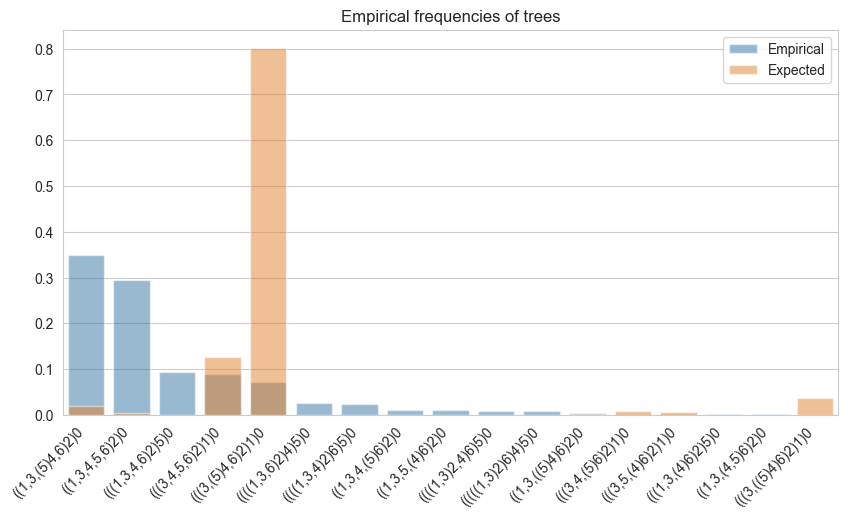

In [37]:
# barplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=[t for t, _ in sorted_trees], y=empirical_freqs, ax=ax, alpha=0.5, label='Empirical')
sns.barplot(x=[t for t, _ in sorted_trees], y=expected_freqs, ax=ax, alpha=0.5, label='Expected')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Empirical frequencies of trees')


<Axes: >

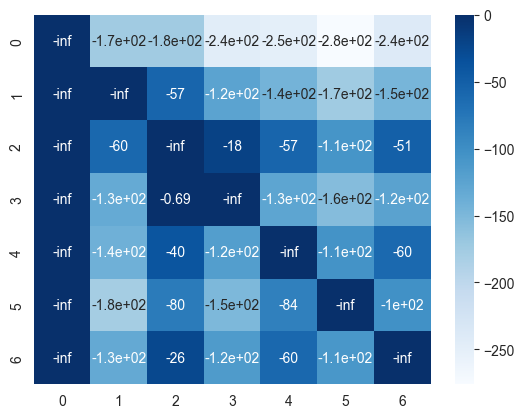

In [27]:
# normalize and try use wilson
norm_matrix = matrix - logsumexp(matrix, axis=0, keepdims=True)
norm_matrix[:, 0] = -np.inf
norm_matrix[np.diag_indices(norm_matrix.shape[0])] = -np.inf
sns.heatmap(matrix, annot=norm_matrix, cmap='Blues')

In [32]:
sample_size = 1
tree_counts_wilson = {} # nwk_tree: (count, weight)
for i in range(sample_size):
    graph = nx.from_numpy_array(np.exp(norm_matrix), create_using=nx.DiGraph())
    tree = wilson_rst(graph, root=0)
    nwk_tree = tree_to_newick(tree)
    tree_w = sum(matrix[u, v] for u, v in tree.edges())
    if nwk_tree not in tree_counts:
        tree_counts[nwk_tree] = (1, tree_w)
    else:
        count, weight = tree_counts[nwk_tree]
        if not np.isclose(weight, tree_w):
            print(tree.edges)
            print([matrix[u, v] for u, v in tree.edges()])
            print(f"Error: {nwk_tree} has different weights {weight} and {tree_w}")
        tree_counts[nwk_tree] = (count + 1, weight)


KeyboardInterrupt: 

In [38]:
# colbourn
sample_size = 1000
tree_counts_colbourn = {} # nwk_tree: (count, weight)
for i in range(sample_size):
    graph = nx.from_numpy_array(np.exp(norm_matrix), create_using=nx.DiGraph())
    tree = colbourn_rst(graph, root=0)
    nwk_tree = tree_to_newick(tree)
    tree_w = sum(matrix[u, v] for u, v in tree.edges())
    if nwk_tree not in tree_counts:
        tree_counts_colbourn[nwk_tree] = (1, tree_w)
    else:
        count, weight = tree_counts_colbourn[nwk_tree]
        if not np.isclose(weight, tree_w):
            print(tree.edges)
            print([matrix[u, v] for u, v in tree.edges()])
            print(f"Error: {nwk_tree} has different weights {weight} and {tree_w}")
        tree_counts_colbourn[nwk_tree] = (count + 1, weight)

IndexError: pop from empty list

# Verification
Try to use Wilson on a slightly different matrix

In [42]:
tree1, tree2 = sorted(sorted_trees, key=lambda x: x[1][1], reverse=True)[:2]
tree1, tree2

(('(((3,(5)4,6)2)1)0', (721, -462.628)), ('(((3,4,5,6)2)1)0', (894, -464.476)))

<Axes: >

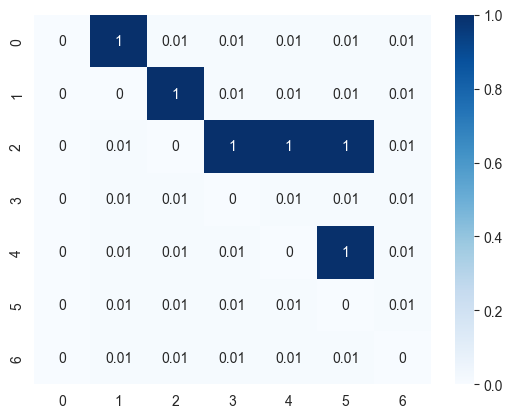

In [43]:
hh = 1. # high weight
ww = 0.01  # weak weight
matrix2 = np.array([[0, hh, ww, ww, ww, ww, ww],
                   [0, 0, hh, ww, ww, ww, ww],
                   [0, ww, 0, hh, hh, hh, ww],
                   [0, ww, ww, 0, ww, ww, ww],
                   [0, ww, ww, ww, 0, hh, ww],
                   [0, ww, ww, ww, ww, 0, ww],
                   [0, ww, ww, ww, ww, ww, 0]])
sns.heatmap(matrix2, annot=True, cmap='Blues')


In [48]:
for i in range(20):
    tree = wilson_rst_from_matrix(matrix2)
    print(tree_to_newick(tree))

ValueError: probabilities do not sum to 1